<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_Week5_FeatureEngineering_and_ModelSelection_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

|--- Clothing <= 0.50
|   |--- Home <= 0.50
|   |   |--- Books <= 0.50
|   |   |   |--- Toys <= 0.50
|   |   |   |   |--- Electronics <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Electronics >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Toys >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Books >  0.50
|   |   |   |--- class: 0
|   |--- Home >  0.50
|   |   |--- class: 0
|--- Clothing >  0.50
|   |--- class: 0

Accuracy predicting churn from department: 0.71
Accuracy with DeptChurnLast: 0.71
Accuracy with names + last churn + spending: 0.60
Random Forest Accuracy: 0.59
Best Grid Search Accuracy: 0.68
RandomForestClassifier(max_features=None, min_samples_leaf=6, n_estimators=200,
                       random_state=14)


<Figure size 1000x600 with 0 Axes>

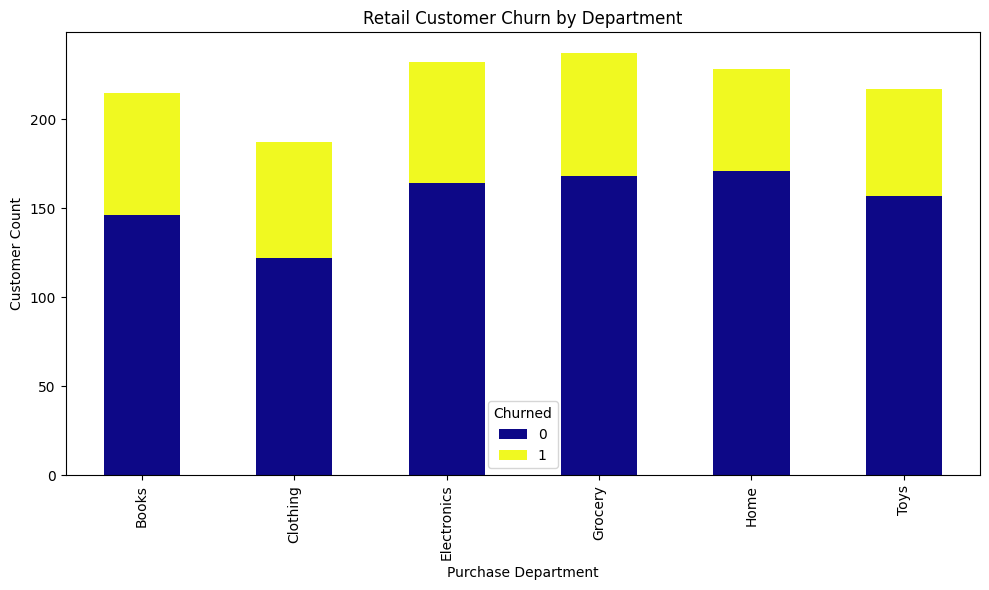

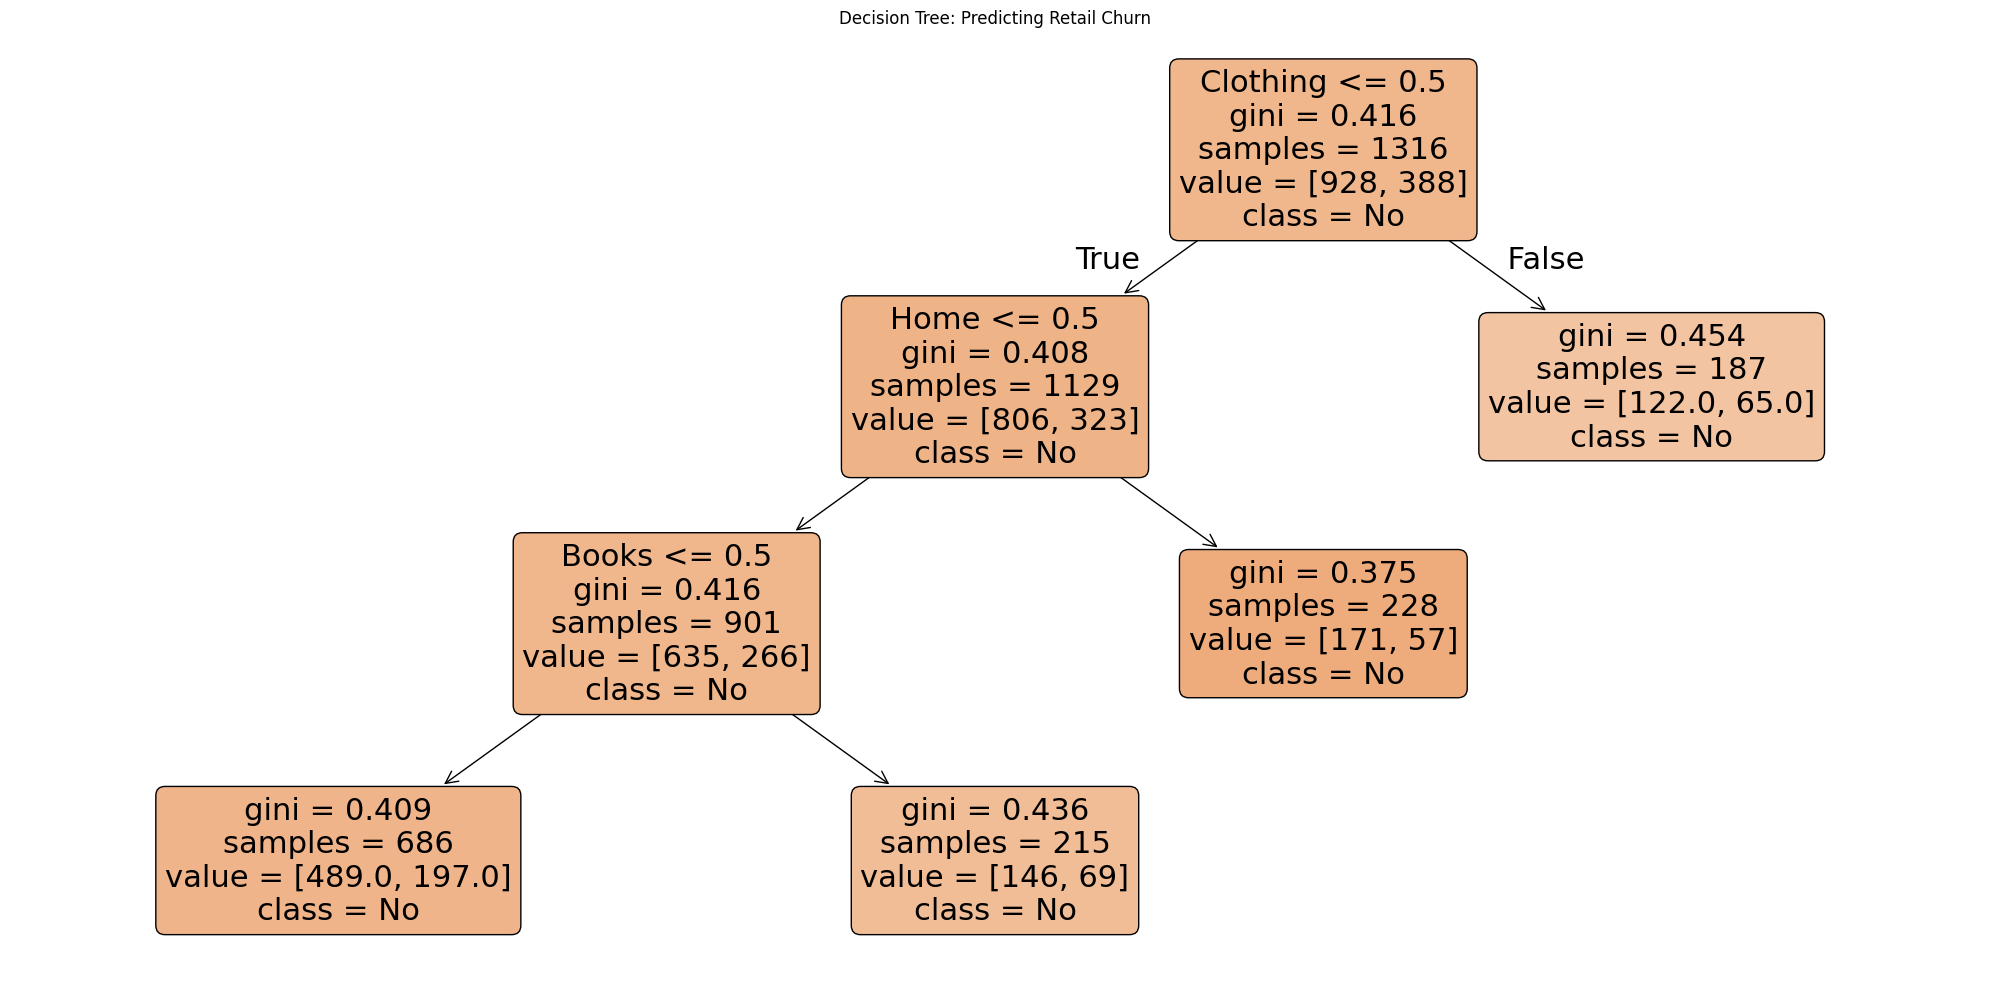

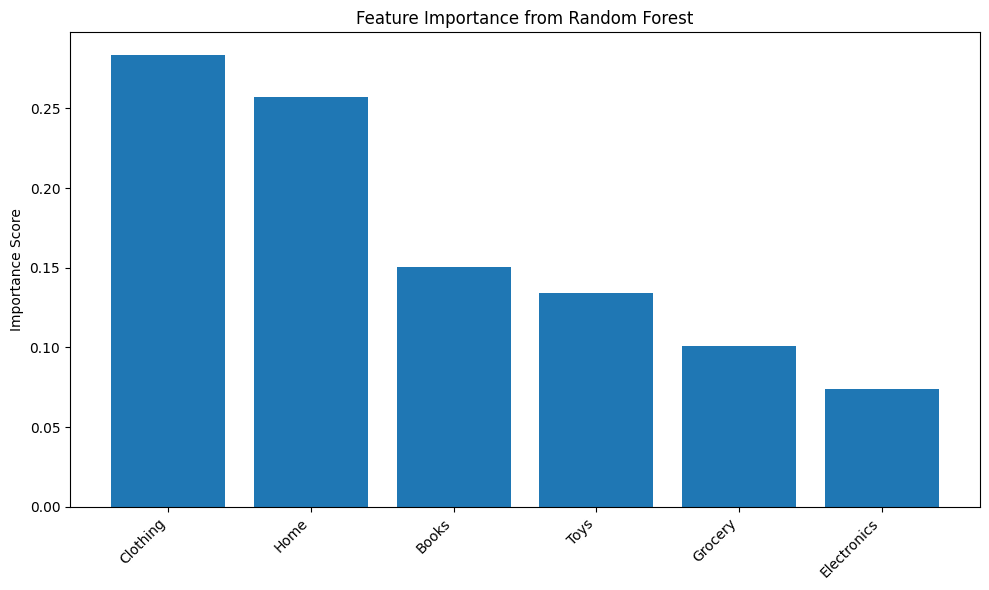

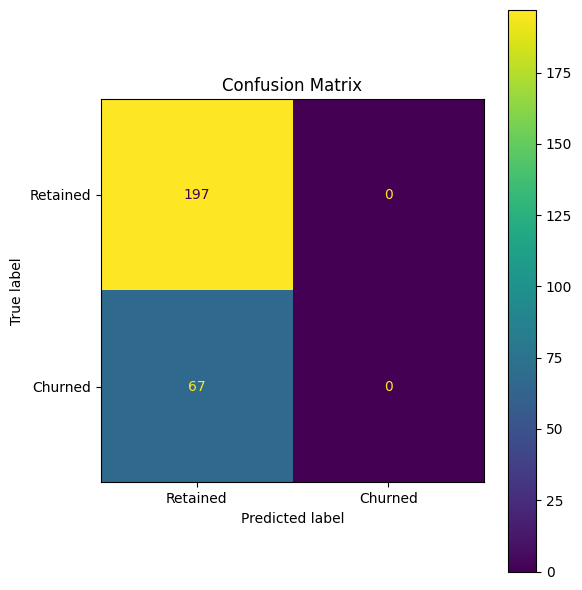

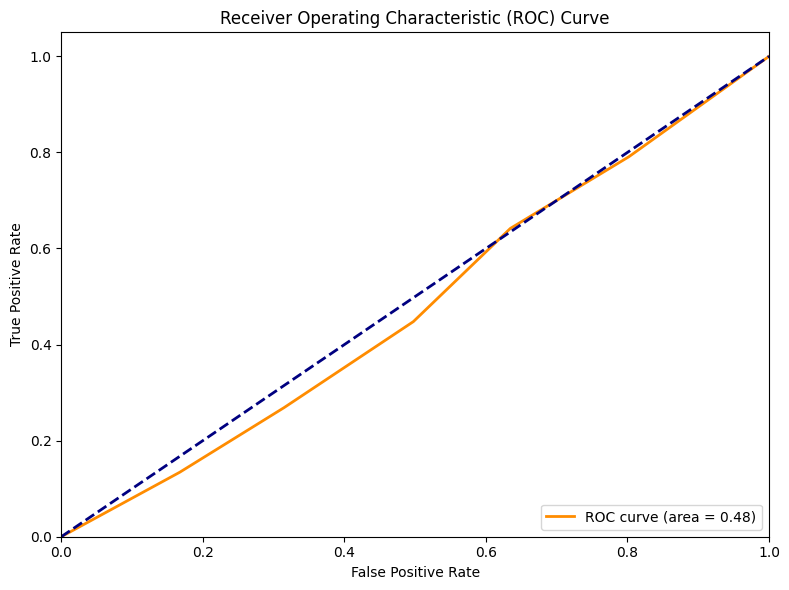

In [1]:
# 📦 RETAIL CUSTOMER CHURN PREDICTION NOTEBOOK

# 1. Imports and Data Creation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

n_customers = 1316
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(days=int(i)) for i in np.random.randint(0, 180, size=n_customers)]
departments = ["Electronics", "Clothing", "Home", "Grocery", "Toys", "Books"]
dept_purchase = np.random.choice(departments, size=n_customers)
age = np.random.randint(18, 80, size=n_customers)
spending = np.random.randint(20, 500, size=n_customers)
churn = np.random.choice([0, 1], size=n_customers, p=[0.7, 0.3])

df = pd.DataFrame({
    "Last Purchase Date": dates,
    "Purchase Department": dept_purchase,
    "Age": age,
    "Spending Amount": spending,
    "Churned": churn
})
df.head()

# 2. Feature Engineering
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(df[["Purchase Department"]])
X = onehot.transform(df[["Purchase Department"]]).toarray()
y_churn = df["Churned"].values

# 3. Basic Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
dt_retail = DecisionTreeClassifier()
dt_retail.fit(X, y_churn)

# 4. View Tree Text
from sklearn.tree import export_text
print(export_text(dt_retail, feature_names=onehot.categories_[0]))

# 5. Train-Test Split and Accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y_churn, test_size=0.2, random_state=42)
dt_retail = DecisionTreeClassifier()
dt_retail.fit(X_train, y_train)
y_pred = dt_retail.predict(X_test)
accuracy_score(y_test, y_pred)

# 6. Cross Validation
from sklearn.model_selection import cross_val_score
dt_retail = DecisionTreeClassifier()
scores = cross_val_score(dt_retail, X, y_churn, cv=10, scoring='accuracy')
print("Accuracy predicting churn from department: {:.2f}".format(np.mean(scores)))

# 7. Add Prior Churn Feature by Department
df['DeptChurnLast'] = 0
from collections import defaultdict
dept_last_churn = defaultdict(int)

for index, row in df.sort_values("Last Purchase Date").iterrows():
    dept = row['Purchase Department']
    df.at[index, 'DeptChurnLast'] = dept_last_churn[dept]
    dept_last_churn[dept] = row['Churned']

# 8. Accuracy with DeptChurnLast only
X_deptLast = df[['DeptChurnLast']]
scores = cross_val_score(DecisionTreeClassifier(), X_deptLast, y_churn, scoring='accuracy', cv=10)
print("Accuracy with DeptChurnLast: {:.2f}".format(np.mean(scores)))

# 9. Combined Features
name_onehot = pd.get_dummies(df['Purchase Department'])
X_combined = pd.concat([name_onehot, df[['DeptChurnLast', 'Spending Amount']]], axis=1)
dt_retail = DecisionTreeClassifier()
scores = cross_val_score(dt_retail, X_combined, y_churn, scoring='accuracy', cv=10)
print("Accuracy with names + last churn + spending: {:.2f}".format(np.mean(scores)))

# 10. Random Forest Model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=14)
scores = cross_val_score(rf, X_combined, y_churn, scoring='accuracy', cv=10)
print("Random Forest Accuracy: {:.2f}".format(np.mean(scores)))

# 11. Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = {
    "max_features": ["sqrt", "log2", None],
    "n_estimators": [100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [2, 4, 6],
}
grid = GridSearchCV(RandomForestClassifier(random_state=14), param_grid)
grid.fit(X_combined, y_churn)
print("Best Grid Search Accuracy: {:.2f}".format(grid.best_score_))
print(grid.best_estimator_)

# 12. Final Model
final_model = grid.best_estimator_
y_pred_final = final_model.predict(X_combined)
accuracy_score(y_churn, y_pred_final)

# 13. Visualization
import matplotlib.pyplot as plt

# Bar Chart
plt.figure(figsize=(10, 6))
df_grouped = df.groupby(['Purchase Department', 'Churned']).size().unstack(fill_value=0)
df_grouped.plot(kind='bar', stacked=True, colormap='plasma', figsize=(10, 6))
plt.title("Retail Customer Churn by Department")
plt.xlabel("Purchase Department")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()

# 14. Decision Tree Visualization
from sklearn.tree import plot_tree

X_dept = onehot.fit_transform(df[["Purchase Department"]]).toarray()
y_churn = df["Churned"].values
dt_model = DecisionTreeClassifier(max_depth=3, random_state=0)
dt_model.fit(X_dept, y_churn)
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt_model, feature_names=onehot.categories_[0], class_names=["No", "Yes"],
          filled=True, rounded=True, ax=ax)
plt.title("Decision Tree: Predicting Retail Churn")
plt.tight_layout()
plt.show()

# 15. Feature Importance (Random Forest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_dept, y_churn)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = np.array(onehot.categories_[0])[indices]
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(importances)), importances[indices], align='center')
ax.set_xticks(range(len(importances)))
ax.set_xticklabels(features, rotation=45, ha='right')
ax.set_title("Feature Importance from Random Forest")
ax.set_ylabel("Importance Score")
plt.tight_layout()
plt.show()

# 16. Confusion Matrix and ROC Curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X_dept, y_churn, test_size=0.2, random_state=0)
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Retained", "Churned"]).plot(ax=ax)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()
